In [161]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

import requests # Reading from web source

# Machine learning
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.cluster import MeanShift

# Data reading and cleaning

In [162]:
# Cell to get the data
# Relevant informations can be found at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

#-------------------------------------------------------
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

print(data.shape)

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ", "_")
                      for n in f.readlines()[1].replace("#", "").replace("\n", "").lstrip().split('    ')
                      if n.strip() != ''])

# Make a dictionary using the headers and the data
data = dict(zip(names, data))

print(names)

(15, 8416)
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [163]:
# Convert data from strings to floats
keys_to_convert = ['ra', 'decl', 'pos_error', 'T90', 'T90_error',
                   'fluence', 'fluence_error', 'redshift', "'T100'", 'mjd_(T0)']

for key in keys_to_convert:
    data[key] = np.array(data[key], dtype=float)

In [164]:
# Mask bad data points
bad_data_mask = (data['T90'] == -999) | (data['fluence'] == -999) | (data['fluence'] == 0)

for key in names:
    data[key] = data[key][~bad_data_mask]

print("Masked " + str(np.sum(bad_data_mask)) + " data points")
print("There are " + str(np.sum(~bad_data_mask)) + " data points left")

Masked 1177 data points
There are 7239 data points left


# Data visualisation

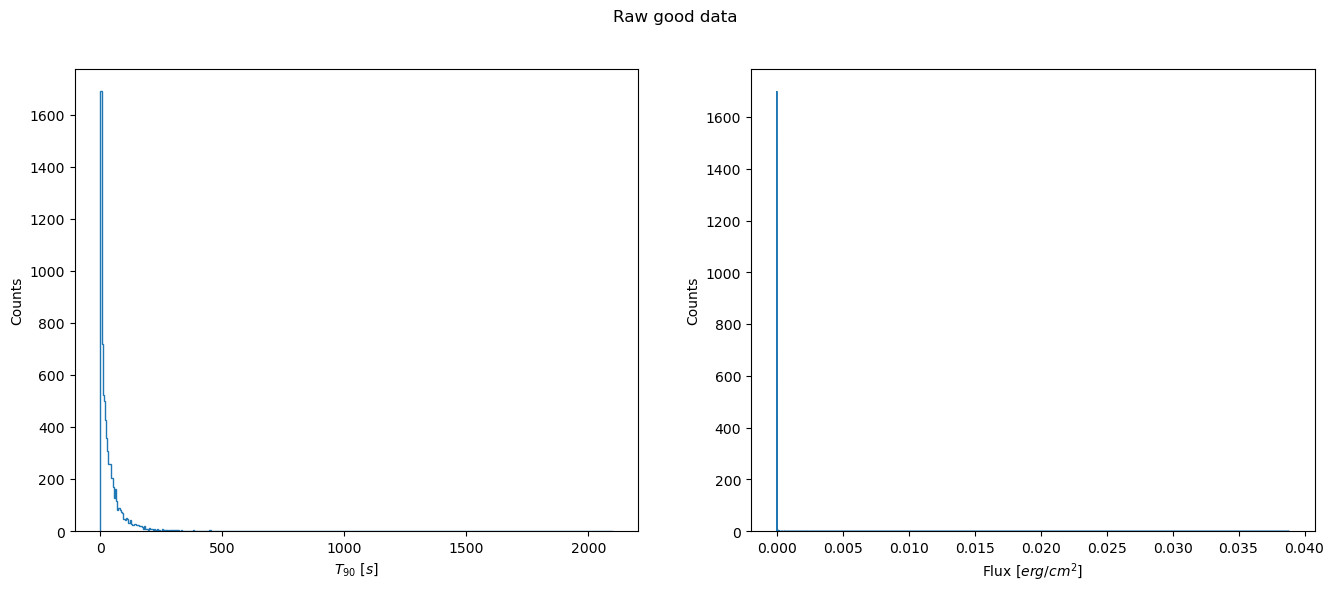

In [165]:
# Make a first plot of T90 and fluence
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle("Raw good data")

ax[0].set_xlabel(r'$T_{90}$ [$s$]')
ax[0].set_ylabel('Counts')
ax[0].hist(data['T90'], bins='auto', histtype='step', density=False)

ax[1].set_xlabel(r'Flux [$erg/cm^2$]')
ax[1].set_ylabel('Counts')
ax[1].hist(data['fluence'], bins='auto', histtype='step', density=False)

plt.show()

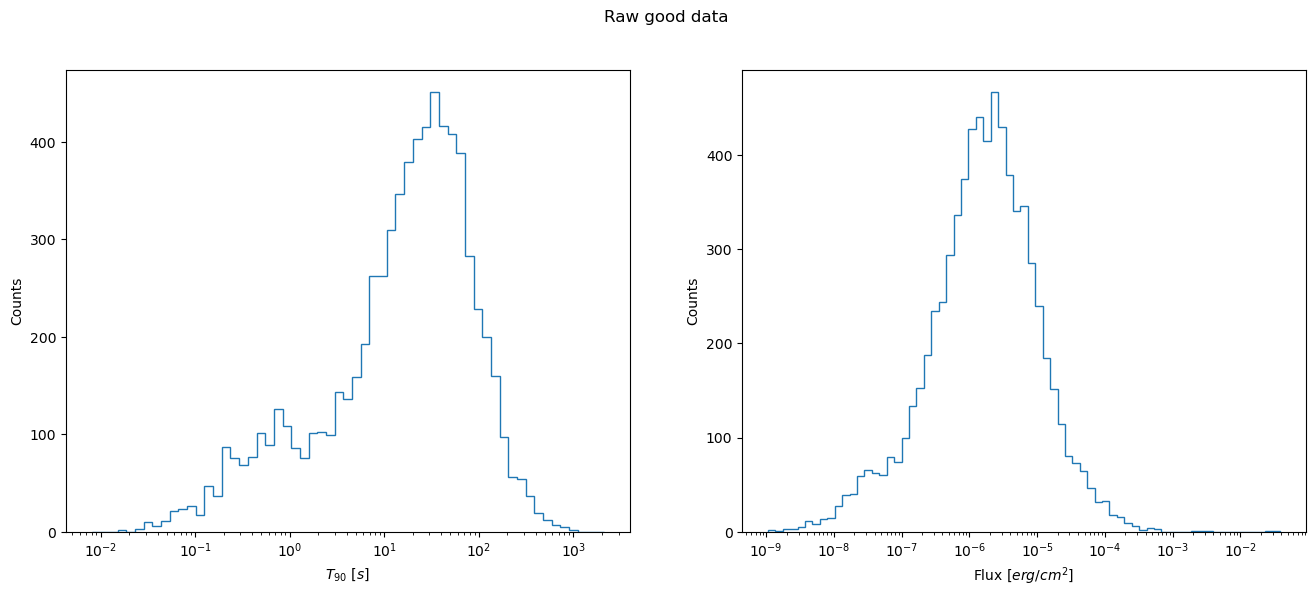

In [166]:
# Switch to log-spaced bins
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle("Raw good data")

# Define the number of bins for each quantity
n_bins = {'T90': 60,
          'fluence': 70}

# Make log-spaced bins for each quantity
bins = dict()
for key in n_bins.keys():
    bins[key] = np.logspace(np.log10(np.min(data[key])), np.log10(np.max(data[key])), n_bins[key])

ax[0].set_xlabel(r'$T_{90}$ [$s$]')
ax[0].set_ylabel('Counts')
ax[0].hist(data['T90'], bins=bins['T90'], histtype='step', density=False)
ax[0].set_xscale('log')

ax[1].set_xlabel(r'Flux [$erg/cm^2$]')
ax[1].set_ylabel('Counts')
ax[1].hist(data['fluence'], bins=bins['fluence'], histtype='step', density=False)
ax[1].set_xscale('log')

plt.show()

In [167]:
# Define support and styles variables
plot_keys = ['T90', 'fluence']
ax_labels = dict(zip(plot_keys, [r'$T_{90}$ [$s$]', r'Flux [$erg/cm^2$]']))
colors = dict(zip(plot_keys, ['mediumblue', 'indianred']))
titles = dict.fromkeys(plot_keys, 'Raw good data')
titles_kde = dict.fromkeys(plot_keys, 'KDE; bandwith = ')

# Compute the quantiles of the the distributions
q = [0.05, 0.5, 0.95]
quantiles = dict(zip(plot_keys, [np.quantile(data[key], q) for key in plot_keys]))
q_styles = [':', '-.', '--']

# KDE bandwith optimisation

In [168]:
# Whether to run the bandwith optimiser or not
optimise_bw = False

# Whether to save the optimised bandwiths or not
save_results = True
bw_file_name = "bw_opt.npz"

#------------------------------------------------------------
# Initialise a variable to store the optimised bandwiths
bw_opt = dict.fromkeys(plot_keys, 0.1)

#------------------------------------------------------------
# Fit the GridSearch to the data
# Note the we pass the log10 of the data because we are watching them on log10 axes
if optimise_bw:
    # Test some bandwidths
    bw_range = np.linspace(0.01, 1.0, 50)
    print(bw_range)

    # Do K-fold cross validation
    K = 5 # 5 is the default value
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bw_range}, cv=K)

    iteration = 1
    for key in plot_keys:
        grid.fit(np.log10(data[key][:, np.newaxis]))

        bw_opt[key] = grid.best_params_['bandwidth']
        print("Iteration " + str(iteration) + ":", bw_opt)

    if save_results:
        np.savez(bw_file_name, T90=bw_opt['T90'], fluence=bw_opt['fluence'])

In [169]:
# Read the optimised bandwiths from a file
# Be sure the results are updated
bw_file = np.load(bw_file_name)

# Convert to float because otherwise you would have 0-D arrays
bw_opt = dict(zip(bw_opt,
                  [float(bw_file[key]) for key in bw_file.keys()]))
bw_file.close()

print("Optimised bandwiths:", bw_opt)

Optimised bandwiths: {'T90': 0.13122448979591836, 'fluence': 0.29285714285714287}


# KDE

In [170]:
# Number of grid points
n_grid_points = 1000

# Define the bandwith for the KDE for each quantity
kde_bandwith = {'T90': bw_opt['T90'], 'fluence': bw_opt['fluence']}

# Create dictionaries to store the results for each quantity
kde = dict.fromkeys(plot_keys)
pdf_kde = dict.fromkeys(plot_keys)
x_grid = dict.fromkeys(plot_keys)

# Compute the KDEs
# Note the we pass the log10 of the data because we are watching them on log10 axes
for key in plot_keys:
    kde[key] = KernelDensity(bandwidth=kde_bandwith[key])
    kde[key].fit(np.log10(data[key][:, np.newaxis]))
    
    x_grid[key] = np.logspace(np.log10(np.min(data[key])), np.log10(np.max(data[key])), n_grid_points)
    pdf_kde[key] = np.exp(kde[key].score_samples(np.log10(x_grid[key][:, np.newaxis])))

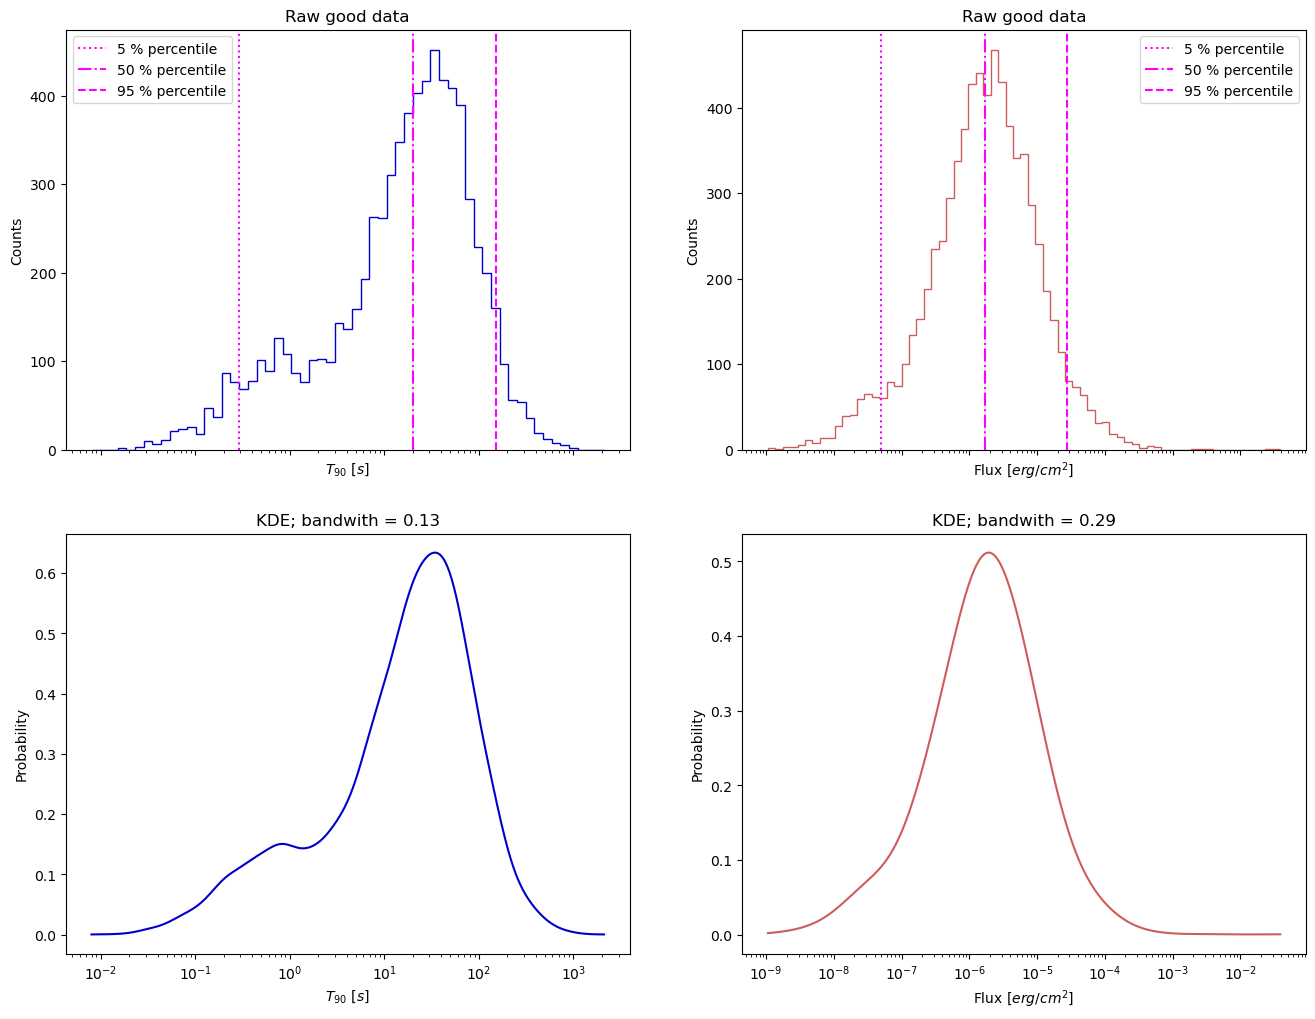

In [171]:
# Plot along with the data
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex='col')

# Row 0: Data
for ax, key in zip(axes[0], plot_keys):
    ax.set_title(titles[key])
    ax.set_xlabel(ax_labels[key])
    ax.set_ylabel('Counts')

    ax.hist(data[key], bins=bins[key], histtype='step', density=False, color=colors[key])
    ax.set_xscale('log')

    for i in range(len(quantiles[key])):
        ax.axvline(quantiles[key][i], linestyle=q_styles[i], color='magenta',
                   label=np.format_float_positional(q[i] * 100, trim='-') + ' % percentile')

    ax.legend()

# Row 1: KDE
for ax, key in zip(axes[1], plot_keys):
    ax.set_title(titles_kde[key] + np.format_float_positional(kde_bandwith[key], 2))
    ax.set_xlabel(ax_labels[key])
    ax.set_ylabel('Probability')

    ax.plot(x_grid[key], pdf_kde[key], color=colors[key])
    ax.set_xscale('log')

plt.show()

From the $T_{90}$ distribution it seems clear that there are 2 populations of GRB. The Flux distribution doesn't show evident bi-modality.

# Flux vs $T_{90}$

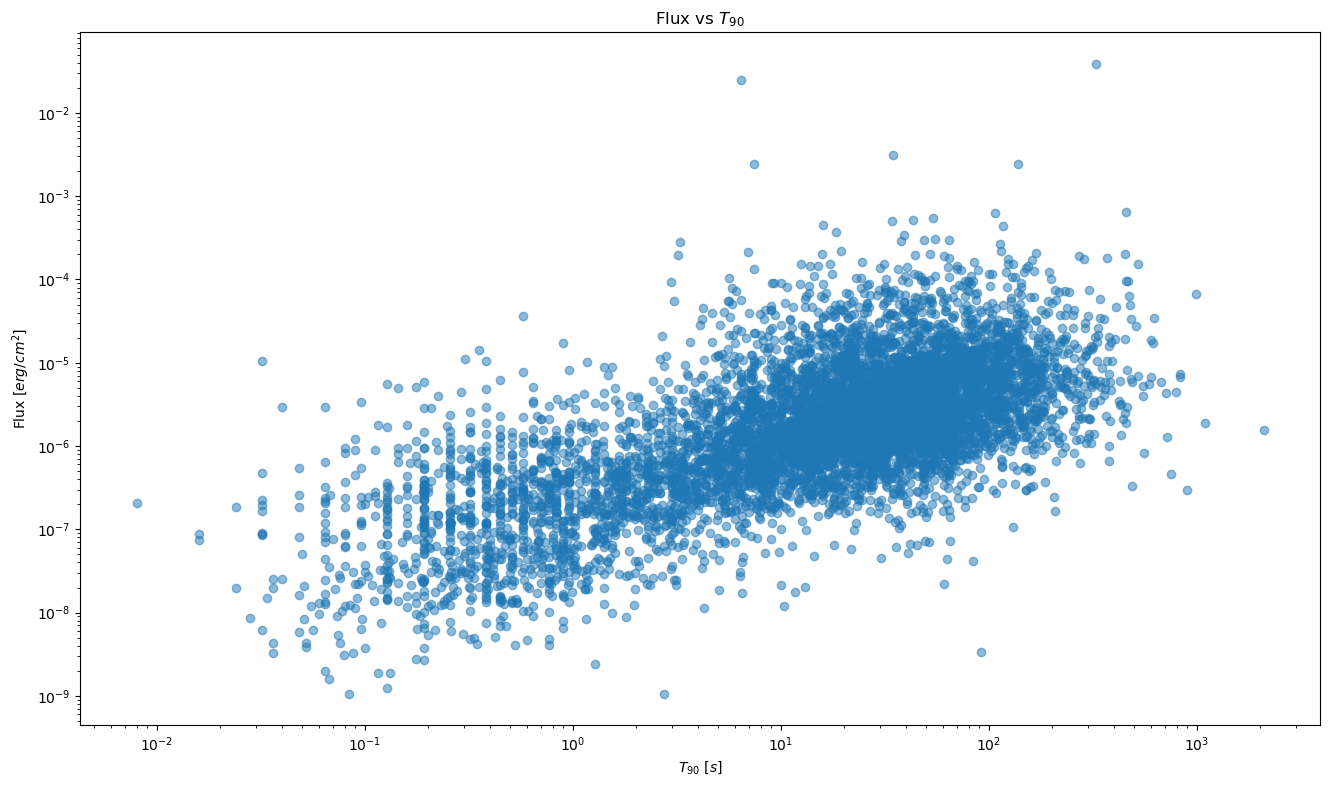

In [172]:
# Plot fluence vs T90
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title(r"Flux vs $T_{90}$")
ax.set_xlabel(ax_labels['T90'])
ax.set_ylabel(ax_labels['fluence'])

ax.scatter(data['T90'], data['fluence'], alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')

plt.show()

In [173]:
# Merge the plotted data in the shape scikit-learn wants
# Note that we are using the log of the data since that's what we are watching
# and also what the algorithm should see
sklearn_data = np.stack([np.log10(data['T90']), np.log10(data['fluence'])], axis=1)

# **KMeans**

Searching for 2 clusters.

In [174]:
# Initialise a KMeans object for clustering estimation
n_clusters = 2
clf = KMeans(n_clusters=n_clusters, n_init='auto')

# Fit to the data
clf.fit(sklearn_data)

KMeans(n_clusters=2)

In [175]:
# Get the cluster each point belong to
labels_KM = clf.predict(sklearn_data)

# Get the centers of the clusters
# Note the exponentiation in order to get back to linear units
centers_KM = 10 ** clf.cluster_centers_

Position of the centers:
[[3.39062093e+01 3.47988864e-06]
 [1.19656514e+00 1.89765594e-07]]


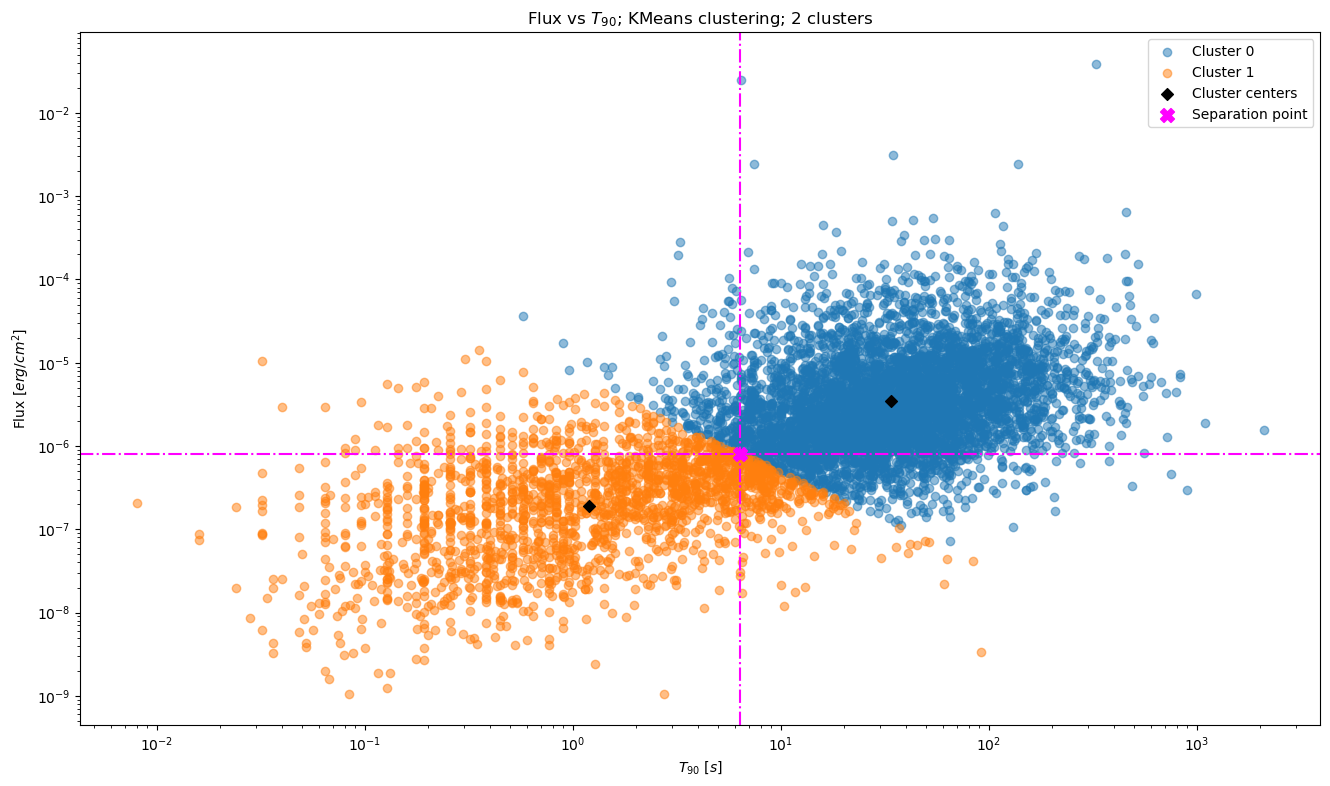

In [176]:
# Plot the data using the predicted labels
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title(r"Flux vs $T_{90}$; KMeans clustering; " + str(len(clf.cluster_centers_)) + " clusters")
ax.set_xlabel(ax_labels['T90'])
ax.set_ylabel(ax_labels['fluence'])

# Save artists and labels while plotting to build the legend
ax_artists = []
labels = []

for cl_label in range(len(clf.cluster_centers_)):
    ax_artists.append(ax.scatter(data['T90'][labels_KM == cl_label], data['fluence'][labels_KM == cl_label],
                                 alpha=0.5, label='Cluster ' + str(cl_label)))
    
    # Plot the centers of the clusters
    c_artist = ax.scatter(centers_KM[cl_label][0], centers_KM[cl_label][1],
                          label = 'Cluster centers', color='black', marker='D',
                          zorder=len(clf.cluster_centers_))
    
    # Save the labels of the plotted cluster
    labels.append(ax_artists[cl_label].get_label())

# Save the center artist and label just once
labels.append(c_artist.get_label())

# Compute the separation point of the 2 clusters by taking the mean point of the line
# that connects the centers. Always be careful to compute everything in log scale
sep_point = 10 ** np.mean(np.log10(centers_KM), axis=0)

# Plot the separation point and save its artist and label
sep_artist = ax.scatter(sep_point[0], sep_point[1],
                        label='Separation point', color='magenta', marker='X', s=100,
                        zorder=len(clf.cluster_centers_))
labels.append(sep_artist.get_label())

# Plot intersection lines in the separation point
ax.axvline(sep_point[0], color='magenta', linestyle='-.')
ax.axhline(sep_point[1], color='magenta', linestyle='-.')

ax.set_xscale('log')
ax.set_yscale('log')

# Build the legend with the saved artists and labels
ax.legend(ax_artists + [c_artist, sep_artist], labels)

# Print the position of the centers
print("Position of the centers:", centers_KM, sep='\n')

plt.show()

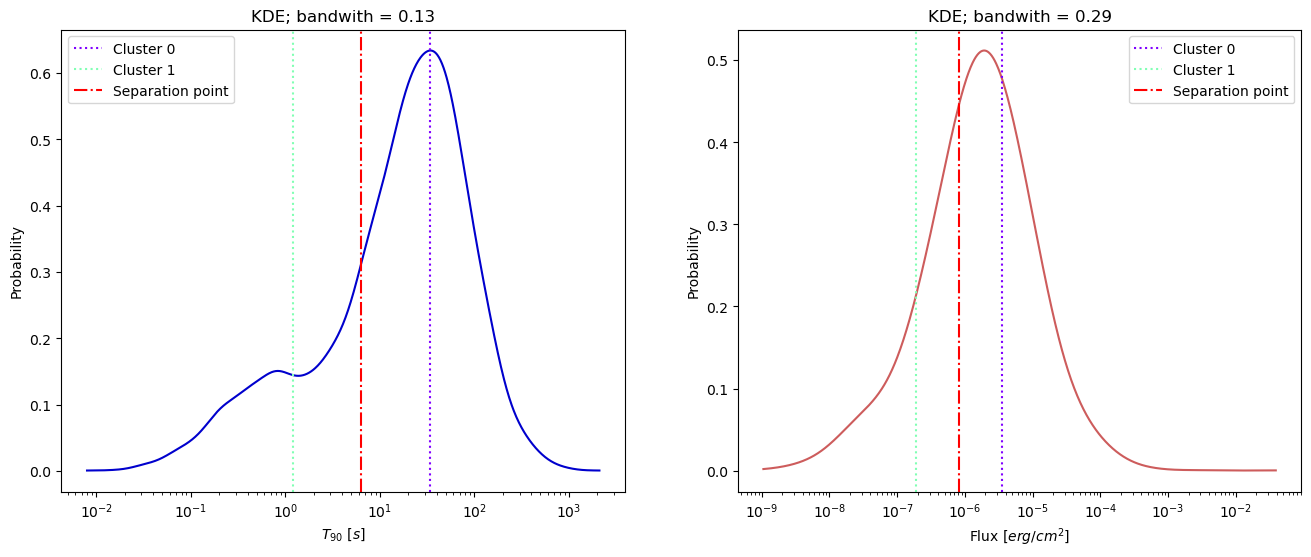

In [177]:
# Plot the KDEs adding the center of the clusters and the separation point
# Remember that T90 is x axis and fluence is y axis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Zip also the integer indexes for the axes: [T90, fluence] -> [0, 1]
for ax, key, key_index in zip(axes, plot_keys, [0, 1]):
    ax.set_title(titles_kde[key] + np.format_float_positional(kde_bandwith[key], 2))
    ax.set_xlabel(ax_labels[key])
    ax.set_ylabel('Probability')

    ax.plot(x_grid[key], pdf_kde[key], color=colors[key])

    # Create a color iterator to give different colors to vertical lines
    # Make it of lenght (len(centers_KM) + 1) to account also for the separation line
    # Use next() to go through the elements of the iterator
    color = iter(plt.cm.rainbow(np.linspace(0, 1, len(centers_KM) + 1)))

    # Plot the position of the clusters
    for cl_label in range(len(centers_KM)):
        ax.axvline(centers_KM[cl_label][key_index],
                   label='Cluster ' + str(cl_label), color=next(color), linestyle=':')
    
    # Plot the separation lines between the clusters
    ax.axvline(sep_point[key_index],
               label='Separation point', color=next(color), linestyle='-.')

    ax.set_xscale('log')

    ax.legend()

plt.show()

# Gaussian mixture on $T_{90}$

In [178]:
# Initialise a GaussianMixture
gm_n_components = 2
gm = GaussianMixture(n_components=gm_n_components)

# Fit to the data
gm.fit(np.log10(data['T90'][:, np.newaxis]))

GaussianMixture(n_components=2)

In [179]:
# Get the results of the fit and convert them to linear scale
# Squeeze them to get rid of the 1-sized axes
gm_means = 10 ** np.squeeze(gm.means_)
gm_covariances = 10 ** np.squeeze(gm.covariances_)

print("GM Means: ", gm_means, sep='\n')
print("\nGM Cov: ", gm_covariances, sep='\n')
print("\nGM Weights: ", gm.weights_, sep='\n')

GM Means: 
[30.82846187  0.97724759]

GM Cov: 
[1.63105654 2.46686392]

GM Weights: 
[0.75921042 0.24078958]


In [180]:
# Compute the gaussian mixture on the T90 grid
pdf_gm = np.exp(gm.score_samples(np.log10(x_grid['T90'][:, np.newaxis])))

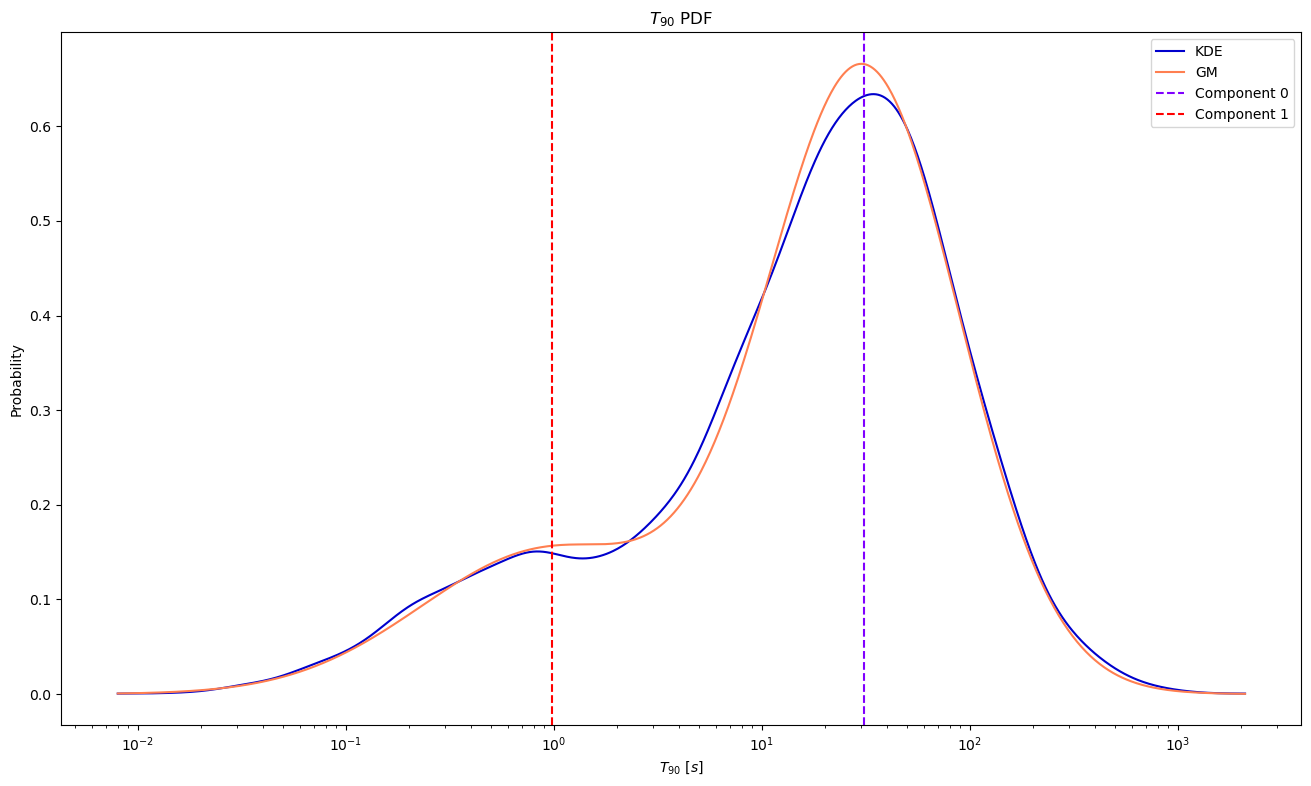

In [181]:
# Over plot the gaussian mixture to the KDE
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title(r'$T_{90}$ PDF')
ax.set_xlabel(ax_labels['T90'])
ax.set_ylabel('Probability')

# Plot the KDE and the GM
ax.plot(x_grid['T90'], pdf_kde['T90'], color=colors['T90'], label='KDE')
ax.plot(x_grid['T90'], pdf_gm, color='coral', label='GM')

# Plot vertical lines on the means of the GM components
color = iter(plt.cm.rainbow(np.linspace(0, 1, gm_n_components)))
for i in range(gm_n_components):
    ax.axvline(gm_means[i],
               label='Component ' + str(i), linestyle='--', color=next(color))

ax.set_xscale('log')

ax.legend()

plt.show()

In [182]:
# Assign a label to every point in T90 based on the GM
# In our case the clusters have the same labels for both the KM and the GM
labels_GM = gm.predict(np.log10(data['T90'][:, np.newaxis]))

In [183]:
# Print the confusion matrix between the KM and the GM predictions
confusion_matrix(labels_KM, labels_GM)

array([[5187,   56],
       [ 483, 1513]])

There is some confusion between the prediction of the 2 methods.

# **MeanShift**

The choice of the bandwith highly impacts the result of the algorithm. MeanShift is also sensitive to outliers. Try the clustering with and without masking the outliers. See the first part of the notebook for data masking.

In [184]:
# Initialise a MeanShift object for clustering estimation
# The bandwith is optional; MeanShift will figure out by its self what bandwith
# to use if no bandwith is given
bandwidth = 0.5 # 0.5 shows some multi-modality in "fluence vs T90"
ms = MeanShift(bin_seeding=True, cluster_all=False, bandwidth=bandwidth)

# Fit to the data
ms.fit(sklearn_data)

MeanShift(bandwidth=0.5, bin_seeding=True, cluster_all=False)

In [185]:
# Get the cluster each point belong to
labels_MS = ms.predict(sklearn_data)

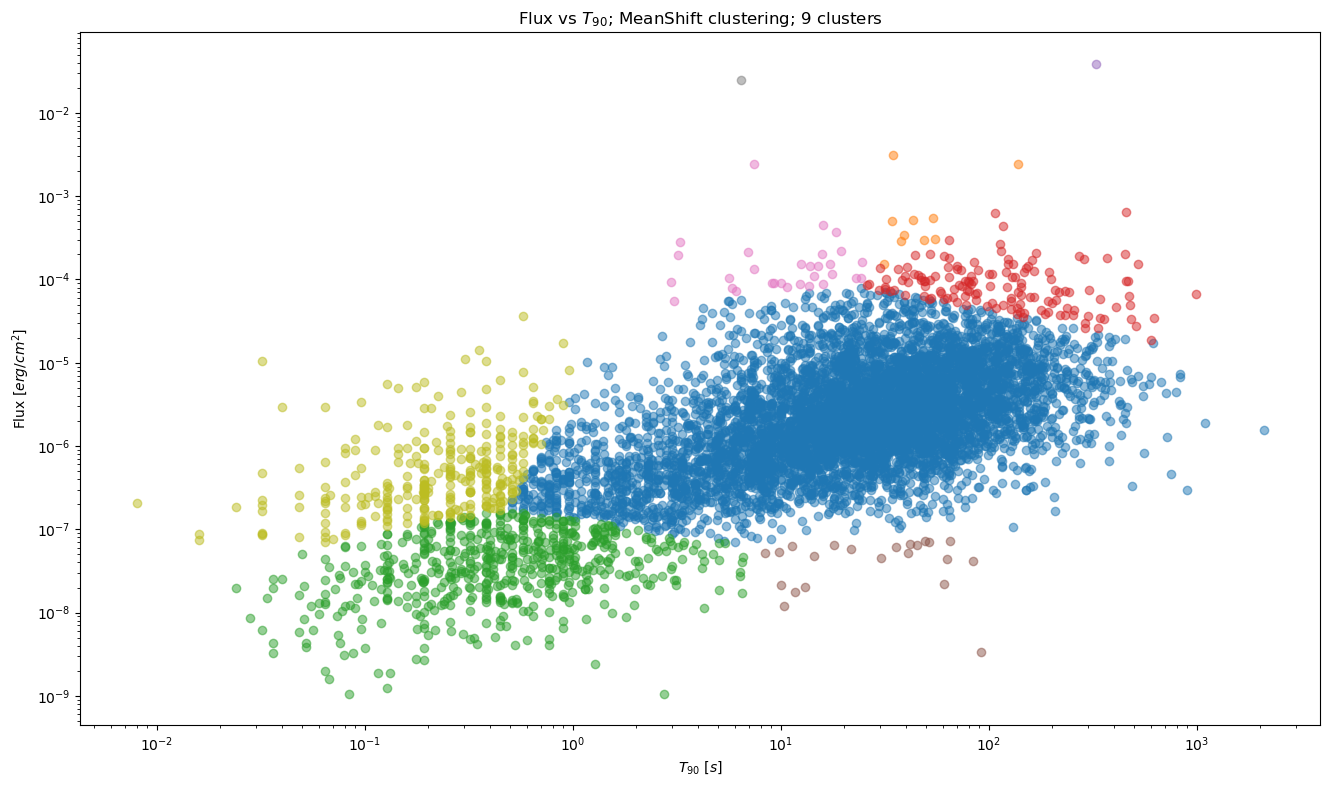

In [186]:
# Plot the data using the predicted labels
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title(r"Flux vs $T_{90}$; MeanShift clustering; " + str(len(ms.cluster_centers_)) + " clusters")
ax.set_xlabel(ax_labels['T90'])
ax.set_ylabel(ax_labels['fluence'])

for i in range(len(ms.cluster_centers_)):
    ax.scatter(data['T90'][labels_MS == i], data['fluence'][labels_MS == i], alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

I don't find MeanShift useful in this context.